In [1]:
from qiskit import *  
from time import time #importamos la función time para capturar tiempos
from qiskit.circuit import Parameter 
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
#librerias para visualizaciones
from qiskit.tools.visualization import plot_state_paulivec
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.visualization import plot_state_city
from qiskit.visualization import plot_bloch_multivector
#python
import numpy as np
import matplotlib.pyplot as plt
import cmath

# Simuladores estandar 
SS = Aer.get_backend('statevector_simulator')
QS = Aer.get_backend('qasm_simulator')

In [2]:
qiskit.__qiskit_version__

{'qiskit-terra': '0.16.1',
 'qiskit-aer': '0.7.1',
 'qiskit-ignis': '0.5.1',
 'qiskit-ibmq-provider': '0.11.1',
 'qiskit-aqua': '0.8.1',
 'qiskit': '0.23.1'}

<h1> Dos spines acoplados </h1>


El Hamiltoniano usado por Ariel en la simulación de la figura 1.b) (del paper: Coding closed and open quantum systems
in MATLAB: applications in quantum
optics and condensed matter) es:
    \begin{eqnarray}
    H = -J \sigma_x^{(1)}\otimes\sigma_x^{(2)}-B(\sigma_x^{(1)}+\sigma_x^{(2)}),
    \end{eqnarray}
es decir, no usa $S_x=\sigma_x/2$ (ver los codigos en el paper). Como todos los operadores de $H$ conmutan no es necesario usar Trotter-Suzuki. La magnetización promedio en $z$ calculada en el paper esta dada por:

\begin{eqnarray}
\langle M_z\rangle = \frac{1}{2}(\langle \sigma_z^{(1)}\rangle + \langle \sigma_z^{(2)}\rangle).
\end{eqnarray}

Consideramos un estado arbitrario $|\psi \rangle$ en el espacio de dos qubits (el cual representa a los dos espines):
\begin{eqnarray}
| \psi \rangle = \alpha | 00 \rangle + \beta | 01\rangle + \gamma |10\rangle + \epsilon |11\rangle.
\end{eqnarray}
Calculando el promedio de $\sigma_z^{(i)}$ en este estado arbitrario obtenemos:
\begin{eqnarray}
\langle\sigma_z^{(1)} \rangle= |\alpha|^2+|\beta|^2-|\gamma|^2-|\epsilon|^2\\
\langle \sigma_z^{(2)} \rangle = |\alpha|^2-|\beta|^2+|\gamma|^2-|\epsilon|^2,\\
\end{eqnarray}
de modo que la magnetización nos queda:
\begin{eqnarray}
\langle M_z\rangle &=& \frac{1}{2}(2|\alpha|^2-2|\epsilon|^2)\\
&=& |\alpha|^2-|\epsilon|^2.
\end{eqnarray}
Dado que $|\alpha|^2$ ($|\epsilon|^2$) es la probabilidad de medir el estado $|00\rangle$ ($|11\rangle$) podemos expresarlos con circuitos cuánticos usando:
\begin{eqnarray}
P_{11} = |\alpha|^2 = \frac{\mbox{N° de veces que se mide 00}}{\mbox{N° total de mediciones}}.
\end{eqnarray}
y lo mismo para $|11\rangle$.

In [2]:
#Este es el circuito para Amplitude Damping
theta = Parameter('θ')
phi = Parameter('ϕ')
qr = QuantumRegister(2,'q')
an = QuantumRegister(1,'ancilla')
cr = ClassicalRegister(1)
qc = QuantumCircuit(qr,an,cr)
n= 4
qc.x(qr[0])
qc.x(qr[1])
for i in range(n):
    qc.rz(theta, qr[0])
    qc.rz(theta, qr[1])
    qc.rxx(phi,qubit1= qr[0],qubit2=qr[1])
    qc.cu(2*theta,0,0,0,qr[0],an[0])
    qc.cx(an[0],qr[0])
    qc.barrier()

qc.measure(qr[0],cr[0])
qc.draw()

┌───┐┌───────┐┌─────────┐                ┌───┐ ░ ┌───────┐»
      q_0: ┤ X ├┤ RZ(θ) ├┤0        ├───────■────────┤ X ├─░─┤ RZ(θ) ├»
           ├───┤├───────┤│  RXX(ϕ) │       │        └─┬─┘ ░ ├───────┤»
      q_1: ┤ X ├┤ RZ(θ) ├┤1        ├───────┼──────────┼───░─┤ RZ(θ) ├»
           └───┘└───────┘└─────────┘┌──────┴───────┐  │   ░ └───────┘»
ancilla_0: ─────────────────────────┤ U(2*θ,0,0,0) ├──■───░──────────»
                                    └──────────────┘      ░          »
     c0: 1/══════════════════════════════════════════════════════════»
                                                                     »
«           ┌─────────┐                ┌───┐ ░ ┌───────┐┌─────────┐»
«      q_0: ┤0        ├───────■────────┤ X ├─░─┤ RZ(θ) ├┤0        ├»
«           │  RXX(ϕ) │       │        └─┬─┘ ░ ├───────┤│  RXX(ϕ) │»
«      q_1: ┤1        ├───────┼──────────┼───░─┤ RZ(θ) ├┤1        ├»
«           └─────────┘┌──────┴───────┐  │   ░ └───────┘└─────────┘»
«ancilla_0: ───────────┤ U(2*θ,0,0,0) ├──■───░─────────────────────»
«                      └──────────────┘      ░                     »
«     c0: 1/═══════════════════════════════════════════════════════»
«                                                                  »
«                           ┌───┐ ░ ┌───────┐┌─────────┐                ┌───┐»
«      q_0: ───────■────────┤ X ├─░─┤ RZ(θ) ├┤0        ├───────■────────┤ X ├»
«                  │        └─┬─┘ ░ ├───────┤│  RXX(ϕ) │       │        └─┬─┘»
«      q_1: ───────┼──────────┼───░─┤ RZ(θ) ├┤1        ├───────┼──────────┼──»
«           ┌──────┴───────┐  │   ░ └───────┘└─────────┘┌──────┴───────┐  │  »
«ancilla_0: ┤ U(2*θ,0,0,0) ├──■───░─────────────────────┤ U(2*θ,0,0,0) ├──■──»
«           └──────────────┘      ░                     └──────────────┘     »
«     c0: 1/═════════════════════════════════════════════════════════════════»
«                                                                            »
«            ░ ┌─┐
«      q_0: ─░─┤M├
«            ░ └╥┘
«      q_1: ─░──╫─
«            ░  ║ 
«ancilla_0: ─░──╫─
«            ░  ║ 
«     c0: 1/════╩═
«               0

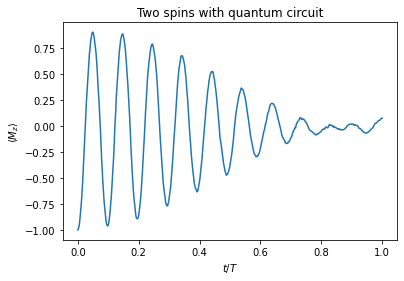

t= 32.39133310317993


In [2]:
# Magnetización vs el tiempo
ti = time()
#parámetros de pérdidas
gamma0=1e-2
lamb=gamma0
c10=1
#parámetros del Hamiltoniano
J = 1
B = 0.1*J
T = np.pi/B
tf = T #hasta aquí, los parametros usados por Ariel para obtener la misma curva
shots = 1024 #el N° total de mediciones
n = 30 #para Trotter-Suzuki
points_t = 500
t=np.linspace(0,tf,points_t) #vector de tiempo que va de 0 a tf
M_z = np.zeros(points_t) #vector de magnetización, inicialmente todo en 0

for j in range(0,points_t):
    qr = QuantumRegister(2,'q')
    an = QuantumRegister(1,'ancilla')
    cr = ClassicalRegister(2,'c')
    qc = QuantumCircuit(qr,an,cr)
    #Condición inicial |down down> == |11>
    qc.x(qr[0])
    qc.x(qr[1]) # las dos puertas X nos deja el estado |11>
    
    for i in range(n): # para el Trotter-Suzuki
        qc.rz(-2*B*t[j]/n,qr[0])
        qc.rz(-2*B*t[j]/n,qr[1])# las puertas del operador evolución a tiempo t[j]
        qc.rxx(-2*J*t[j]/(n),qr[0],qr[1]) # 
   
        R=gamma0/lamb 
        c1=c10*np.exp(-lamb*t[j]/2)*(cmath.cosh(lamb*t[j]*cmath.sqrt(1-2*R)/2)+ cmath.sinh(lamb*t[j]*cmath.sqrt(1-2*R)/2)/cmath.sqrt(1-2*R))
        theta=np.arccos(c1.real)        

        qc.cu(2*theta,0,0,0,qr[0],an[0])
        qc.cx(an[0],qr[0])
    
    qc.measure(qr[0],cr[0])
    qc.measure(qr[1],cr[1])
    job = execute(qc, QS, shots = shots, seed_simulator = 1000)
    result = job.result()
    counts = result.get_counts()
    if '00' in counts:
        M_z[j] += (counts['00']/shots) #probabilidad de medir 00, se suma 
    if '11' in counts:
        M_z[j] -= (counts['11']/shots) #probabilidad de medir 11, se resta
        #Se guarda el M_z[j] resultante a tiempo t[j] 

    


#Gráfico        
tt = t/T
plt.plot(tt,M_z)
plt.xlabel(r'$t/T$')
plt.ylabel(r'$\langle M_z\rangle $')
plt.title(r'Two spins with quantum circuit')
plt.show()  
        
tf = time()

total = tf-ti
print('t=',total)

## Importante
Tener en consideración que, para Qiskit, las compuertas que estamos usando son así:
#### RXX

$$
        R_{XX}(\theta) = exp(-i \frac{\theta}{2} X{\otimes}X) =
            \begin{pmatrix}
                \cos(\frac{\theta}{2})   & 0           & 0           & -i\sin(\frac{\theta}{2}) \\
                0           & \cos(\frac{\theta}{2})   & -i\sin(\frac{\theta}{2}) & 0 \\
                0           & -i\sin(\frac{\theta}{2}) & \cos(\frac{\theta}{2})   & 0 \\
                -i\sin(\frac{\theta}{2}) & 0           & 0           & \cos(\frac{\theta}{2})
            \end{pmatrix}
$$
Fuente: <https://qiskit.org/documentation/stubs/qiskit.circuit.library.RXXGate.html>

#### RZ
$$
RZ(\lambda) = exp(-i\frac{\lambda}{2}Z) =
            \begin{pmatrix}
                e^{-i\frac{\lambda}{2}} & 0 \\
                0 & e^{i\frac{\lambda}{2}}
            \end{pmatrix}
$$
Fuente: <https://qiskit.org/documentation/stubs/qiskit.circuit.library.RZGate.html>